<a href="https://colab.research.google.com/github/GokayToga/FloodNet_Challange-GT/blob/main/FloodNet_Challange_GT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To Do:

*   Resize the images to 713x713 ✅
*   Augment the images with random shuffling, scaling, flipping, and random rotation ✅
*  First Build basic U-net to experiment ✅
  - Masking problems occured after ploting solve them.✅
  - Recheck the model. ✅
*   Train the model properly with time. (trained for 15h) ✅
*  Solve class imbalance problem
  - Try Oversampling (Best method but takes time)
  - Try Undersampling (Not as good but cuts on time) ✅
  - A combination of thresholding and baseline and oversampling is best
  - Trying Dropout could bennefit the model
*  Improve the model by implementing PSPNet ✅
*  Then PSPNet, ENet, and DeepLabv3+ can be implemented and experimented on.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries :

In [26]:
import tensorflow as tf
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np
import pandas as pd
import cv2
import imageio
import scipy


from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter

from tensorflow.image import resize as tf_resize
from tensorflow import io as tf_io
from tensorflow import image as tf_image

from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
!pip3 install tqdm

In [ ]:
import tensorflow as tf

# Check available devices
devices = tf.config.list_physical_devices()
print("Available devices:", devices)

# Check which device TensorFlow is currently using
print("TensorFlow is using device:", tf.test.gpu_device_name())


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
TensorFlow is using device: 


### Data Resizing and Augmentation

In [ ]:
Data_struct = """
|
│   class_mapping.csv
│
└──>Test
│   │
│   └──>Labeled img (.png)
│       │
│       └──> images
│   │
│   └──>Unlabeled img (.jpg)
│       │
│       └──> images
└──>Train
│   │
│   └──>Labeled img (.png)
│       │
│       └──> images
│   │
│   └──>Unlabeled img (.jpg)
│       │
│       └──> images
└──>val
    │
    └──>Labeled img (.png)
        │
        └──> images
    │
    └──>Unlabeled img (.jpg)
        │
        └──> images
"""

# Data Augmentation/Segmentation :




In [ ]:


RESIZE = (713,713) #shape of resized image
drive_path = "/content/drive/MyDrive/FloodNet-Supervised_v1.0"
local_path = "/content/Augmented_Data"

def Augment_Resize2(path, resize=RESIZE):
  used_path = drive_path + path
  save_format = os.path.splitext(used_path)[1].lower()


  if len(os.listdir(used_path)) > 1:

    length = len(os.listdir(used_path))

    for img_name in tqdm(os.listdir(used_path)):
      img_path = used_path + "/" + img_name
      save_path = local_path + path + "/" + img_name

      try:
          img = imageio.imread(img_path)
      except Exception as e:
          print(f"Error: {e}")
          continue

      # Check if the image was read successfully
      if img is not None:

        img = cv2.resize(img, resize)
        imageio.imwrite(save_path, img)

      else:
        print(f"Error: Unable to read image at {img_path}")
  else:
    print(f"{path}  images are already saved")


In [ ]:
#Test
Augment_Resize2("/test/test-label-img")
Augment_Resize2("/test/test-org-img")

#Train
Augment_Resize2("/train/train-label-img")
Augment_Resize2("/train/train-org-img")

#Val
Augment_Resize2("/val/val-label-img")
Augment_Resize2("/val/val-org-img")



  0%|          | 0/448 [00:00<?, ?it/s]<ipython-input-3-d434104c1896>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
100%|██████████| 450/450 [02:45<00:00,  2.73it/s]


-Moving the data to Drive

In [ ]:
!mv /content/Augmented_Data /content/drive/MyDrive


-Downloading the data

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/Augmented_Data')

## Transforming and Augmenting Data

In [27]:
SEGMENTS = {'Background':0,'Building-flooded':1,'Building-non-flooded':2,'Road-flooded':3,'Road-non-flooded':4,
         'Water':5,'Tree':6,'Vehicle':7,'Pool':8,'Grass':9}
DIMENSIONS = (713,713)

In [28]:

Aug_parameters = ImageDataGenerator(   #augmentation parameters
      rescale=1./255,          # Scaling
      horizontal_flip=True,    # Random horizontal flip
      vertical_flip=True,      # Random vertical flip
      rotation_range=45        # Random rotation in the range [-45, 45] degrees
  )

Aug_parameters_test = ImageDataGenerator(   #augmentation parameters
      rescale=1./255          # Scaling
  )

In [77]:
import scipy
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

class SegDataset(tf.keras.utils.Sequence):
    def __init__(self, x_paths, y_labels, batch_size, transform=None):
        self.x_paths = x_paths
        self.y_labels = y_labels
        self.batch_size = batch_size
        self.transform = transform

    def __len__(self):
        return len(self.x_paths) // self.batch_size

    def __getitem__(self, index):
        batch_x_paths = self.x_paths[index * self.batch_size: (index + 1) * self.batch_size]
        batch_y_labels = self.y_labels[index * self.batch_size: (index + 1) * self.batch_size]

        batch_images = [cv2.imread(path) for path in batch_x_paths]
        batch_labels = batch_y_labels

        if self.transform:
            batch_images = self.transform.flow(batch_images, batch_size=len(batch_images), shuffle=False)

        batch_images = [cv2.resize(img, DIMENSIONS) / 255.0 for img in batch_images]

        return tf.convert_to_tensor(batch_images, dtype=tf.float32), tf.convert_to_tensor(batch_labels, dtype=tf.int64)


class SegDataset4(tf.keras.utils.Sequence):#for resizing if needed for training performance
    def __init__(self, x_paths, y_labels, batch_size, transform=None, target_size=(256, 256)):
        self.x_paths = x_paths
        self.y_labels = y_labels
        self.batch_size = batch_size
        self.transform = transform
        self.target_size = target_size  # Set  desired target size

    def __len__(self):
        return len(self.x_paths) // self.batch_size

    def __getitem__(self, index):
        #print(f"__getitem__ method called for index: {index}")
        batch_x_paths = self.x_paths[index * self.batch_size: (index + 1) * self.batch_size]
        batch_y_labels = self.y_labels[index * self.batch_size: (index + 1) * self.batch_size]

        batch_images = [cv2.imread(path) for path in batch_x_paths]
        batch_masks = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in batch_y_labels]

        # Resize images and masks
        batch_images = [cv2.resize(img, self.target_size) / 255.0 for img in batch_images]
        batch_masks = [cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST) for mask in batch_masks]

        #for img in batch_images:
         #   plt.imshow(img)
        #    plt.show()

        if self.transform:
            # Create an instance of ImageDataGenerator and apply the flow method
            datagen = self.transform.flow(np.array(batch_images), batch_size=len(batch_images), shuffle=False)
            augmented_images = datagen.next()

            augmented_masks = np.array(batch_masks)

            batch_images = augmented_images
            batch_masks = augmented_masks
        '''

        #BUG TESTING

        # Inside SegDataset4 __getitem__ method
        print(f"Image Path: {batch_x_paths}")
        print(f"Mask Path: {batch_y_labels}")

        print(f"Image Size: {batch_images[0].shape}")
        print(f"Mask Size: {batch_masks[0].shape}")

        print(f"Unique Mask Values: {np.unique(batch_masks[0])}")


        # Plot a single image and mask
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)

        # Manually scale pixel values to the valid range (0 to 1)
        scaled_image = (batch_images[0] - np.min(batch_images[0])) / (np.max(batch_images[0]) - np.min(batch_images[0]))

        plt.imshow(scaled_image)
        plt.title('Input Image')
        plt.show()

        plt.subplot(1, 2, 2)
        plt.imshow(batch_masks[0], cmap='viridis', vmin=0, vmax=255)
        plt.title('Mask')

        plt.show()
        '''

        return tf.convert_to_tensor(batch_images, dtype=tf.float32), tf.convert_to_tensor(batch_masks, dtype=tf.int64)

#ONE HOT ENCODING
class SegDataset5(tf.keras.utils.Sequence):
    def __init__(self, x_paths, y_labels, batch_size, transform=None, target_size=(256, 256), num_classes=10):
        self.x_paths = x_paths
        self.y_labels = y_labels
        self.batch_size = batch_size
        self.transform = transform
        self.target_size = target_size  # Set desired target size
        self.num_classes = num_classes

    def __len__(self):
        return len(self.x_paths) // self.batch_size

    def __getitem__(self, index):
        batch_x_paths = self.x_paths[index * self.batch_size: (index + 1) * self.batch_size]
        batch_y_labels = self.y_labels[index * self.batch_size: (index + 1) * self.batch_size]

        batch_images = [cv2.imread(path) for path in batch_x_paths]
        batch_masks = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in batch_y_labels]

        # Resize images and masks
        batch_images = [cv2.resize(img, self.target_size) / 255.0 for img in batch_images]
        batch_masks = [cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST) for mask in batch_masks]

        if self.transform:
            datagen = self.transform.flow(np.array(batch_images), batch_size=len(batch_images), shuffle=False)
            augmented_images = datagen.next()

            augmented_masks = np.array(batch_masks)

            batch_images = augmented_images
            batch_masks = augmented_masks

        # One-hot encode masks
        batch_masks_onehot = tf.one_hot(tf.convert_to_tensor(batch_masks, dtype=tf.int64), self.num_classes)

        return tf.convert_to_tensor(batch_images, dtype=tf.float32), batch_masks_onehot

#UNDERSAMPLING
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler

class SegDataset6(tf.keras.utils.Sequence):
    def __init__(self, x_paths, y_labels, batch_size, transform=None, target_size=(256, 256), num_classes=10):
        self.x_paths = x_paths
        self.y_labels = y_labels
        self.batch_size = batch_size
        self.transform = transform
        self.target_size = target_size  # Set desired target size
        self.num_classes = num_classes

    def __len__(self):
        return len(self.x_paths) // self.batch_size

    def undersample_data(self, x_paths, y_labels):
        x_images = [cv2.imread(path) for path in x_paths]
        y_masks = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in y_labels]

        # Resize images and masks
        x_images = [cv2.resize(img, self.target_size) / 255.0 for img in x_images]
        y_masks = [cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST) for mask in y_masks]

        # Flatten the image data
        x_flattened = np.array(x_images).reshape(len(x_images), -1)
        y_flattened = np.array(y_masks).reshape(len(y_masks), -1)

        # Shuffle the data before undersampling
        x_flattened, y_flattened = shuffle(x_flattened, y_flattened, random_state=42)

        # Apply undersampling
        under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
        x_resampled, y_resampled = under_sampler.fit_resample(x_flattened, y_flattened.ravel())

        # Reshape the undersampled data back to the original format
        x_resampled = x_resampled.reshape(-1, *self.target_size, 3)
        y_resampled = y_resampled.reshape(-1, *self.target_size, 1)

        return x_resampled, y_resampled

    def __getitem__(self, index):
        batch_x_paths = self.x_paths[index * self.batch_size: (index + 1) * self.batch_size]
        batch_y_labels = self.y_labels[index * self.batch_size: (index + 1) * self.batch_size]

        # Undersample the data
        batch_images, batch_masks = self.undersample_data(batch_x_paths, batch_y_labels)

        if self.transform:
            datagen = self.transform.flow(np.array(batch_images), batch_size=len(batch_images), shuffle=False)
            augmented_images = datagen.next()

            augmented_masks = np.array(batch_masks)

            batch_images = augmented_images
            batch_masks = augmented_masks

        # One-hot encode masks
        batch_masks_onehot = tf.one_hot(tf.convert_to_tensor(batch_masks, dtype=tf.int64), self.num_classes)

        return tf.convert_to_tensor(batch_images, dtype=tf.float32), batch_masks_onehot

from imblearn.under_sampling import NearMiss
#NEAR-MISS UNDERSAMPLING
class SegDataset7(tf.keras.utils.Sequence):
    def __init__(self, x_paths, y_labels, batch_size, transform=None, target_size=(256, 256), num_classes=10):
        self.x_paths = x_paths
        self.y_labels = y_labels
        self.batch_size = batch_size
        self.transform = transform
        self.target_size = target_size  # Set desired target size
        self.num_classes = num_classes

    def __len__(self):
        return len(self.x_paths) // self.batch_size

    def undersample_data(self, x_paths, y_labels):
        x_images = [cv2.imread(path) for path in x_paths]
        y_masks = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in y_labels]

        # Resize images and masks
        x_images = [cv2.resize(img, self.target_size) / 255.0 for img in x_images]
        y_masks = [cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST) for mask in y_masks]

        # Flatten the image data
        x_flattened = np.array(x_images).reshape(len(x_images), -1)
        y_flattened = np.array(y_masks).reshape(len(y_masks), -1)

        # Shuffle the data before undersampling
        x_flattened, y_flattened = shuffle(x_flattened, y_flattened, random_state=42)
        y_flattened_1d = np.max(y_flattened, axis=1)


        # Apply near miss undersampling
        near_miss = NearMiss(sampling_strategy='auto' , n_neighbors=2)
        x_resampled, y_resampled = near_miss.fit_resample(x_flattened, y_flattened_1d)

        # Reshape the undersampled data back to the original format
        x_resampled = x_resampled.reshape(-1, *self.target_size, 3)

        print("Before Reshape - y_resampled shape:", y_resampled.shape, "size:", y_resampled.size)

        y_resampled_reshaped = y_resampled.reshape(-1, *self.target_size, self.num_classes)

        print("After Reshape - y_resampled_reshaped shape:", y_resampled_reshaped.shape, "size:", y_resampled_reshaped.size)

        return x_resampled, y_resampled

    def __getitem__(self, index):
        batch_x_paths = self.x_paths[index * self.batch_size: (index + 1) * self.batch_size]
        batch_y_labels = self.y_labels[index * self.batch_size: (index + 1) * self.batch_size]

        # Undersample the data
        batch_images, batch_masks = self.undersample_data(batch_x_paths, batch_y_labels)

        if self.transform:
            datagen = self.transform.flow(np.array(batch_images), batch_size=len(batch_images), shuffle=False)
            augmented_images = datagen.next()

            augmented_masks = np.array(batch_masks)

            batch_images = augmented_images
            batch_masks = augmented_masks

        # One-hot encode masks
        batch_masks_onehot = tf.one_hot(tf.convert_to_tensor(batch_masks, dtype=tf.int64), self.num_classes)

        return tf.convert_to_tensor(batch_images, dtype=tf.float32), batch_masks_onehot

#NEAR-MISS UNDERSAMPLING 2
class SegDataset8(tf.keras.utils.Sequence):
    def __init__(self, x_paths, y_labels, batch_size, transform=None, target_size=(256, 256), num_classes=10):
        self.x_paths = x_paths
        self.y_labels = y_labels
        self.batch_size = batch_size
        self.transform = transform
        self.target_size = target_size  # Set desired target size
        self.num_classes = num_classes

    def __len__(self):
        return len(self.x_paths) // self.batch_size

    def undersample_data(self, x_paths, y_labels):
        x_images = [cv2.imread(path) for path in x_paths]
        y_masks = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in y_labels]

        # Resize images
        x_images = [cv2.resize(img, self.target_size) / 255.0 for img in x_images]

        # Convert masks to integer labels
        y_labels_int = [tf.argmax(y_mask, axis=-1).numpy() for y_mask in y_masks]

        # Flatten y_labels_int
        y_labels_int_flat = np.concatenate(y_labels_int)

        # Ensure consistent number of samples
        min_samples = min(len(x_images), len(y_labels_int_flat))
        x_images = x_images[:min_samples]
        y_labels_int_flat = y_labels_int_flat[:min_samples]

        # Shuffle the data before undersampling
        x_images, y_labels_int_flat = shuffle(x_images, y_labels_int_flat, random_state=42)

        # Convert back to numpy arrays
        x_images = np.array(x_images)

        # Under sampling
        near_miss = NearMiss(sampling_strategy='auto', n_neighbors=2)
        x_resampled, y_resampled = near_miss.fit_resample(x_images.reshape(-1, np.prod(self.target_size) * 3), y_labels_int_flat)

        # Check the shape of y_resampled before reshaping
        print("Before Reshape - y_resampled shape:", y_resampled.shape, "size:", y_resampled.size)

        # Reshape the undersampled data back to the original format
        x_resampled = x_resampled.reshape(-1, *self.target_size, 3)
        y_resampled = y_resampled.reshape(-1, *self.target_size, 10)  # Assuming 1 channel for segmentation labels

        return x_resampled, y_resampled



    def __getitem__(self, index):
        batch_x_paths = self.x_paths[index * self.batch_size: (index + 1) * self.batch_size]
        batch_y_labels = self.y_labels[index * self.batch_size: (index + 1) * self.batch_size]

        # Undersample the data
        batch_images, batch_masks = self.undersample_data(batch_x_paths, batch_y_labels)

        if self.transform:
            datagen = self.transform.flow(np.array(batch_images), batch_size=len(batch_images), shuffle=False)
            augmented_images = datagen.next()

            augmented_masks = np.array(batch_masks)

            batch_images = augmented_images
            batch_masks = augmented_masks

        # One-hot encode masks
        batch_masks_onehot = tf.one_hot(tf.convert_to_tensor(batch_masks, dtype=tf.int64), self.num_classes)

        return tf.convert_to_tensor(batch_images, dtype=tf.float32), batch_masks_onehot


from sklearn.utils import shuffle

class SegDatasetWithUndersampling(tf.keras.utils.Sequence):
    def __init__(self, x_paths, y_labels, batch_size, transform=None, target_size=(384, 384), num_classes=10, undersample=True):
        self.x_paths = x_paths
        self.y_labels = y_labels
        self.batch_size = batch_size
        self.transform = transform
        self.target_size = target_size
        self.num_classes = num_classes
        self.undersample = undersample

        if self.undersample:
            self.train_indices, self.val_indices = self.split_train_val_indices()


    def calculate_class_distribution(self, indices):
        # Calculate the number of samples for each class
        class_distribution = {i: 0 for i in range(self.num_classes)}
        for index in indices:
            label_path = self.y_labels[index]
            mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)
            unique, counts = np.unique(mask, return_counts=True)
            class_distribution.update(dict(zip(unique, counts)))

        return class_distribution


    def generate_indices(self):
        # Generate indices for undersampling
        min_samples = min(self.class_distribution.values())
        indices = {i: [] for i in range(self.num_classes)}

        for i, label_path in enumerate(self.y_labels):
            mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)
            unique, counts = np.unique(mask, return_counts=True)
            sample_class = unique[np.argmin(counts)]
            indices[sample_class].append(i)

        for i in range(self.num_classes):
            indices[i] = shuffle(indices[i])[:min_samples]

        return indices

    def split_train_val_indices(self):
        all_indices = np.arange(len(self.x_paths))
        train_indices, val_indices = train_test_split(all_indices, test_size=0.2, random_state=42)

        if self.undersample:
            train_class_distribution = self.calculate_class_distribution(train_indices)
            min_samples = min(train_class_distribution.values())

            train_indices_undersampled = {i: [] for i in range(self.num_classes)}
            for i in train_indices:
                label_path = self.y_labels[i]
                mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)
                unique, counts = np.unique(mask, return_counts=True)
                sample_class = unique[np.argmin(counts)]
                train_indices_undersampled[sample_class].append(i)

            for i in range(self.num_classes):
                train_indices_undersampled[i] = shuffle(train_indices_undersampled[i])[:min_samples]

            train_indices = [item for sublist in train_indices_undersampled.values() for item in sublist]

        return train_indices, val_indices

    def __len__(self):
        if self.undersample:
            return len(self.train_indices) // self.batch_size
        else:
            return len(self.x_paths) // self.batch_size


    def __getitem__(self, index):
        if self.undersample:
            batch_indices = self.train_indices[index * self.batch_size: (index + 1) * self.batch_size]
        else:
            batch_indices = np.arange(index * self.batch_size, (index + 1) * self.batch_size)

        batch_x_paths = [self.x_paths[i] for i in batch_indices]
        batch_y_labels = [self.y_labels[i] for i in batch_indices]

        batch_images = [cv2.imread(path) for path in batch_x_paths]
        batch_masks = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in batch_y_labels]

        # Resize images and masks
        batch_images = [cv2.resize(img, self.target_size) / 255.0 for img in batch_images]
        batch_masks = [cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST) for mask in batch_masks]

        if self.transform:
            datagen = self.transform.flow(np.array(batch_images), batch_size=len(batch_images), shuffle=False)
            augmented_images = datagen.next()

            augmented_masks = np.array(batch_masks)

            batch_images = augmented_images
            batch_masks = augmented_masks

        # Convert masks to integer type
        batch_masks = [tf.convert_to_tensor(mask, dtype=tf.int32) for mask in batch_masks]

        # One-hot encode masks
        batch_masks_onehot = [tf.one_hot(mask, self.num_classes) for mask in batch_masks]

        return tf.convert_to_tensor(batch_images, dtype=tf.float32), tf.convert_to_tensor(batch_masks_onehot, dtype=tf.float32)


class SegDatasetWithUndersampling_NE(tf.keras.utils.Sequence):#NO ONE HOT ENCODING VERSION FOR  PSPNet
    def __init__(self, x_paths, y_labels, batch_size, transform=None, target_size=(384, 384), num_classes=10, undersample=True):
        self.x_paths = x_paths
        self.y_labels = y_labels
        self.batch_size = batch_size
        self.transform = transform
        self.target_size = target_size
        self.num_classes = num_classes
        self.undersample = undersample

        if self.undersample:
            self.train_indices, self.val_indices = self.split_train_val_indices()


    def calculate_class_distribution(self, indices):
        class_distribution = {i: 0 for i in range(self.num_classes)}
        for index in indices:
            label_path = self.y_labels[index]
            mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)
            unique, counts = np.unique(mask, return_counts=True)
            class_distribution.update(dict(zip(unique, counts)))

        return class_distribution


    def generate_indices(self):
        min_samples = min(self.class_distribution.values())
        indices = {i: [] for i in range(self.num_classes)}

        for i, label_path in enumerate(self.y_labels):
            mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)
            unique, counts = np.unique(mask, return_counts=True)
            sample_class = unique[np.argmin(counts)]
            indices[sample_class].append(i)

        for i in range(self.num_classes):
            indices[i] = shuffle(indices[i])[:min_samples]

        return indices

    def split_train_val_indices(self):
        all_indices = np.arange(len(self.x_paths))
        train_indices, val_indices = train_test_split(all_indices, test_size=0.2, random_state=42)

        if self.undersample:
            train_class_distribution = self.calculate_class_distribution(train_indices)
            min_samples = min(train_class_distribution.values())

            train_indices_undersampled = {i: [] for i in range(self.num_classes)}
            for i in train_indices:
                label_path = self.y_labels[i]
                mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)
                unique, counts = np.unique(mask, return_counts=True)
                sample_class = unique[np.argmin(counts)]
                train_indices_undersampled[sample_class].append(i)

            for i in range(self.num_classes):
                train_indices_undersampled[i] = shuffle(train_indices_undersampled[i])[:min_samples]

            train_indices = [item for sublist in train_indices_undersampled.values() for item in sublist]

        return train_indices, val_indices

    def __len__(self):
        if self.undersample:
            return len(self.train_indices) // self.batch_size
        else:
            return len(self.x_paths) // self.batch_size


    def __getitem__(self, index):
        if self.undersample:
            batch_indices = self.train_indices[index * self.batch_size: (index + 1) * self.batch_size]
        else:
            batch_indices = np.arange(index * self.batch_size, (index + 1) * self.batch_size)

        batch_x_paths = [self.x_paths[i] for i in batch_indices]
        batch_y_labels = [self.y_labels[i] for i in batch_indices]

        batch_images = [cv2.imread(path) for path in batch_x_paths]
        batch_masks = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in batch_y_labels]

        batch_images = [cv2.resize(img, self.target_size) / 255.0 for img in batch_images]
        batch_masks = [cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST) for mask in batch_masks]

        if self.transform:
            datagen = self.transform.flow(np.array(batch_images), batch_size=len(batch_images), shuffle=False)
            augmented_images = datagen.next()

            augmented_masks = np.array(batch_masks)

            batch_images = augmented_images
            batch_masks = augmented_masks

        return tf.convert_to_tensor(batch_images, dtype=tf.float32), tf.convert_to_tensor(batch_masks, dtype=tf.float32)



In [ ]:
#Data pathways or sm
#path : /content/drive/MyDrive/Augmented_Data
#specific path : /content/drive/MyDrive/Augmented_Data/test/test-label-img

# Model :



*   First Configuration



In [76]:

def create_paths(base_path, dataset_type):
    labeled_path = base_path + '/' + dataset_type

    image_paths = []
    label_paths = []

    for class_folder in os.listdir(labeled_path):
        if not class_folder.startswith('.'):  # Exclude hidden folders
            class_path = labeled_path

            if os.path.isdir(class_path) and class_folder == (dataset_type + '-org-img'):
                org_images_path = class_path + '/' + class_folder

                if os.path.isdir(org_images_path):
                    image_paths += [org_images_path + '/' + filename for filename in os.listdir(org_images_path)]

            if os.path.isdir(class_path) and class_folder == (dataset_type + '-label-img'):
                labeled_images_path = class_path + '/' + class_folder

                if os.path.isdir(labeled_images_path):
                    label_paths += [labeled_images_path + '/' + filename for filename in os.listdir(labeled_images_path)]

    return image_paths, label_paths

def create_paths_PC(base_path, dataset_type):
    labeled_path = os.path.join(base_path, dataset_type)

    image_paths = []
    label_paths = []

    for class_folder in os.listdir(labeled_path):
        if not class_folder.startswith('.'):  # Exclude hidden folders
            class_path = os.path.join(labeled_path, class_folder)

            if os.path.isdir(class_path) and class_folder == (dataset_type + '-org-img'):
                org_images_path = os.path.join(class_path, class_folder)

                if os.path.isdir(org_images_path):
                    image_paths += [os.path.join(org_images_path, filename) for filename in os.listdir(org_images_path)]

            if os.path.isdir(class_path) and class_folder == (dataset_type + '-label-img'):
                labeled_images_path = os.path.join(class_path, class_folder)

                if os.path.isdir(labeled_images_path):
                    label_paths += [os.path.join(labeled_images_path, filename) for filename in os.listdir(labeled_images_path)]

    return image_paths, label_paths


#for TESTING small dataset
base_dataset_path = 'D:\JN\Augmented_Data'

#"D:\JN\Test_Augment_Data"
#D:\JN\Test_Augmented_Data
#"D:\JN\Test_Augment_Data\test\test-label-img"

#base_dataset_path = 'D:\JN\Augmented_Data'
#/Users/gokaytoga/Downloads/Augmented_Data --Mac path
#/content/drive/MyDrive/Augmented_Data --Drive path
#"D:\JN\Augmented_Data"  -- PC path

# Create paths for training data
x_train, y_train = create_paths(base_dataset_path, 'train')
# Create paths for test data
x_test, y_test = create_paths(base_dataset_path, 'test')
# Create paths for val data
x_val, y_val = create_paths(base_dataset_path, 'val')

# Print the first few paths for verification
print(x_train[:5])
print(y_train[:5])

batch_size = 8

#/Downloads/Augmented_Data/train
#/Downloads/Augmented_Data/train
#/Downloads/Augmented_Data/train

['D:\\JN\\Augmented_Data/train/train-org-img/10165.jpg', 'D:\\JN\\Augmented_Data/train/train-org-img/10166.jpg', 'D:\\JN\\Augmented_Data/train/train-org-img/10168.jpg', 'D:\\JN\\Augmented_Data/train/train-org-img/10170.jpg', 'D:\\JN\\Augmented_Data/train/train-org-img/10171.jpg']
['D:\\JN\\Augmented_Data/train/train-label-img/10165_lab.png', 'D:\\JN\\Augmented_Data/train/train-label-img/10166_lab.png', 'D:\\JN\\Augmented_Data/train/train-label-img/10168_lab.png', 'D:\\JN\\Augmented_Data/train/train-label-img/10170_lab.png', 'D:\\JN\\Augmented_Data/train/train-label-img/10171_lab.png']




*   Class weights



In [69]:
#Class weights

from sklearn.utils.class_weight import compute_class_weight

unique_classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)



*   Data sets



In [ ]:
#Original dataset for size=713 and big dataset
'''
train_dataset = SegDataset3(x_train, y_train, batch_size=batch_size, transform = Aug_parameters)
test_dataset = SegDataset3(x_test, y_test, batch_size=batch_size, transform=None)  # No augmentation for the test set
val_dataset = SegDataset3(x_val, y_val, batch_size=batch_size, transform = Aug_parameters)
'''

In [ ]:
#THIS PART IS FOR USE WHEN COMPUTING PERFORMANCE PROBLEMS OCCUR

#Testing dataset size=512 and smal test data set of 20 imgs
'''
target_size = (512, 512)
train_dataset = SegDataset4(x_train, y_train, batch_size=batch_size, transform = Aug_parameters, target_size=target_size)
test_dataset = SegDataset4(x_test, y_test, batch_size=batch_size, transform=Aug_parameters_test, target_size=target_size)  # No augmentation for the test set
val_dataset = SegDataset4(x_val, y_val, batch_size=batch_size, transform = Aug_parameters, target_size=target_size)
'''

In [ ]:
#THIS PART IS FOR ONE-HOT ENCODING
target_size = (512, 512)
num_classes = 10
train_dataset = SegDataset5(x_train, y_train, batch_size=batch_size, transform = Aug_parameters, target_size=target_size, num_classes=num_classes)
test_dataset = SegDataset5(x_test, y_test, batch_size=batch_size, transform=Aug_parameters_test, target_size=target_size, num_classes=num_classes)  # No augmentation for the test set
val_dataset = SegDataset5(x_val, y_val, batch_size=batch_size, transform = Aug_parameters, target_size=target_size, num_classes=num_classes)

image_datasets = {'train_set': train_dataset, 'test_set': test_dataset}



*   Class imbalance fixed Data sets



In [ ]:
#RANDOM UNDERSAMPLING METHOD
target_size = (512, 512)
num_classes = 10
train_dataset = SegDataset6(x_train, y_train, batch_size=batch_size, transform = Aug_parameters, target_size=target_size, num_classes=num_classes)
test_dataset = SegDataset6(x_test, y_test, batch_size=batch_size, transform=Aug_parameters_test, target_size=target_size, num_classes=num_classes)  # No augmentation for the test set
val_dataset = SegDataset6(x_val, y_val, batch_size=batch_size, transform = Aug_parameters, target_size=target_size, num_classes=num_classes)

image_datasets = {'train_set': train_dataset, 'test_set': test_dataset}

In [ ]:
from imblearn.under_sampling import NearMiss

#NEAR-MISS UNDERSAMPLING METHOD

target_size = (512, 512)
num_classes = 10
train_dataset = SegDataset8(x_train, y_train, batch_size=batch_size, transform = Aug_parameters, target_size=target_size, num_classes=num_classes)
test_dataset = SegDataset8(x_test, y_test, batch_size=batch_size, transform=Aug_parameters_test, target_size=target_size, num_classes=num_classes)  # No augmentation for the test set
val_dataset = SegDataset8(x_val, y_val, batch_size=batch_size, transform = Aug_parameters, target_size=target_size, num_classes=num_classes)


image_datasets = {'train_set': train_dataset, 'test_set': test_dataset}

In [79]:
#UNDERSAMPLING METHOD updated

target_size = (384, 384)
num_classes = 10
train_dataset = SegDatasetWithUndersampling(x_train, y_train, batch_size=batch_size, transform=Aug_parameters, target_size=target_size, num_classes=num_classes, undersample=True)
val_dataset = SegDatasetWithUndersampling(x_val, y_val, batch_size=batch_size, transform=Aug_parameters, target_size=target_size, num_classes=num_classes, undersample=True)
test_dataset = SegDatasetWithUndersampling(x_test, y_test, batch_size=batch_size, transform=Aug_parameters_test, target_size=target_size, num_classes=num_classes,undersample=False)  # No undersampling for the test set

image_datasets = {'train_set': train_dataset, 'test_set': test_dataset}

In [65]:
#UNDERSAMPLING METHOD updated without one-hot encoding

target_size = (384, 384)
num_classes = 10
train_dataset = SegDatasetWithUndersampling_NE(x_train, y_train, batch_size=batch_size, transform=Aug_parameters, target_size=target_size, num_classes=num_classes, undersample=True)
val_dataset = SegDatasetWithUndersampling_NE(x_val, y_val, batch_size=batch_size, transform=Aug_parameters, target_size=target_size, num_classes=num_classes, undersample=False)
test_dataset = SegDatasetWithUndersampling_NE(x_test, y_test, batch_size=batch_size, transform=Aug_parameters, target_size=target_size, num_classes=num_classes, undersample=False)  # No undersampling for the test set

image_datasets = {'train_set': train_dataset, 'test_set': test_dataset}



*   The model:



In [81]:
#### UNET CONFIG #########
ENCODER_DEPTH=5
DECODER_CHANNELS=(256, 128, 64, 32, 16)
BATCH_SIZE= [8, 16, 32, 64, 128]
BATCH_SIZE = [8]
EPOCHS= 100

Tensorflow model example (for later use):

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[713, 713, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[DIMENSIONS, DIMENSIONS, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)



*   My Unet model:




In [ ]:
input_shape = (512,512,3)
#input_shape = (713, 713, 3)

class ResizeLayer(layers.Layer):
    def __init__(self, target_shape, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_shape = target_shape

    def call(self, inputs):
        return tf.image.resize(inputs, self.target_shape)

    def get_config(self):
        config = super(ResizeLayer, self).get_config()
        config.update({'target_shape': self.target_shape})
        return config

# Register ResizeLayer as a custom layer
tf.keras.utils.get_custom_objects()['ResizeLayer'] = ResizeLayer

def conv_block(x, filters, kernel_size, activation='relu'):
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

def unet_model(input_shape=input_shape, num_classes=10):
    # Encoder
    inputs = tf.keras.Input(shape=input_shape)
    conv1 = conv_block(inputs, 64, 3)
    conv1 = conv_block(conv1, 64, 3)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128, 3)
    conv2 = conv_block(conv2, 128, 3)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256, 3)
    conv3 = conv_block(conv3, 256, 3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = conv_block(pool3, 512, 3)
    conv4 = conv_block(conv4, 512, 3)

    # Decoder
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    resize5 = ResizeLayer(target_shape=(conv3.shape[1], conv3.shape[2]))(up5)
    concat5 = layers.Concatenate()([resize5, conv3])
    conv5 = conv_block(concat5, 256, 3)
    conv5 = conv_block(conv5, 256, 3)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    resize6 = ResizeLayer(target_shape=(conv2.shape[1], conv2.shape[2]))(up6)
    concat6 = layers.Concatenate()([resize6, conv2])
    conv6 = conv_block(concat6, 128, 3)
    conv6 = conv_block(conv6, 128, 3)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    resize7 = ResizeLayer(target_shape=(conv1.shape[1], conv1.shape[2]))(up7)
    concat7 = layers.Concatenate()([resize7, conv1])
    conv7 = conv_block(concat7, 64, 3)
    conv7 = conv_block(conv7, 64, 3)

    # Output layer
    output = layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = tf.keras.Model(inputs=inputs, outputs=output, name='unet_model')
    return model




*   PSPNet implementation:



In [21]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [83]:
#implementation of PSPNet using Segmentation Models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
sm.set_framework('tf.keras')

OUTPUT_CLASSES = 10
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
train_dataset = preprocess_input(train_dataset)
val_dataset = preprocess_input(val_dataset)


'''
# Check if there is a saved model checkpoint
if os.path.exists('model_checkpoint.h5'):
    # Load the saved model
    model = load_model('model_checkpoint.h5')
else:
    # Create a new model if no saved model is found
    model = sm.PSPNet(BACKBONE)
'''

# define model
model = sm.PSPNet(
    backbone_name= BACKBONE,
    input_shape=(384, 384, 3),
    classes=10,
    activation='softmax',
    encoder_weights='imagenet',
    encoder_freeze=False,
    downsample_factor=8,
    psp_conv_filters=512,
    psp_pooling_type='avg',
    psp_use_batchnorm=True,
    psp_dropout=None
)

# Compile the model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'] )

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks, class_weight=dict(enumerate(class_weights)))

env: SM_FRAMEWORK=tf.keras
Epoch 1/100
1/1 [==============================] - 31s 31s/step - loss: 3.1078 - accuracy: 0.0344 - val_loss: 2.1790 - val_accuracy: 0.1015
Epoch 2/100
1/1 [==============================] - 22s 22s/step - loss: 1.9888 - accuracy: 0.4364 - val_loss: 2.0871 - val_accuracy: 0.0829
Epoch 3/100
1/1 [==============================] - 23s 23s/step - loss: 1.7145 - accuracy: 0.4824 - val_loss: 2.0026 - val_accuracy: 0.5047
Epoch 4/100
1/1 [==============================] - 22s 22s/step - loss: 1.6685 - accuracy: 0.5550 - val_loss: 1.8716 - val_accuracy: 0.5412
Epoch 5/100
1/1 [==============================] - 22s 22s/step - loss: 1.7600 - accuracy: 0.5278 - val_loss: 1.7738 - val_accuracy: 0.5332
Epoch 6/100
1/1 [==============================] - 23s 23s/step - loss: 1.4273 - accuracy: 0.5310 - val_loss: 1.7214 - val_accuracy: 0.5382
Epoch 7/100
1/1 [==============================] - 22s 22s/step - loss: 1.2813 - accuracy: 0.5538 - val_loss: 1.7079 - val_accuracy: 

In [82]:
model.summary()


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 384, 384, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_180 (ZeroPa  (None, 390, 390, 3)          0         ['bn_data[0][0]']             
 dding2D)                                                                                         
                                                                                           



# Training the model:




In [ ]:
OUTPUT_CLASSES = 10

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['mIoU'])

In [ ]:
from tensorflow.keras.models import load_model
'''
custom_objects = {'ResizeLayer': ResizeLayer}

# Check if there is a saved model checkpoint
if os.path.exists('model_checkpoint.h5'):
    # Load the saved model
    model = load_model('model_checkpoint.h5')
else:
    # Create a new model if no saved model is found
    model = unet_model()
'''
model = unet_model()

# Compile the model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'] )

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# Train the model
#@tf.autograph.experimental.do_not_convert
model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks, class_weight=dict(enumerate(class_weights)))

Epoch 1/40

2/2 [==============================] - ETA: 0s - loss: 2.5127 - accuracy: 0.1505  

C:\Users\togag\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 895s 773s/step - loss: 2.5127 - accuracy: 0.1505 - val_loss: 2.3038 - val_accuracy: 0.0392
Epoch 2/40
2/2 [==============================] - 779s 660s/step - loss: 2.2603 - accuracy: 0.2511 - val_loss: 2.3524 - val_accuracy: 0.0307
Epoch 3/40
2/2 [==============================] - 741s 644s/step - loss: 2.0080 - accuracy: 0.3599 - val_loss: 2.5478 - val_accuracy: 0.0284
Epoch 4/40
2/2 [==============================] - 858s 731s/step - loss: 1.8566 - accuracy: 0.4613 - val_loss: 4.0711 - val_accuracy: 0.0213
Epoch 5/40
2/2 [==============================] - 832s 734s/step - loss: 1.7418 - accuracy: 0.4754 - val_loss: 5.8931 - val_accuracy: 0.4822
Epoch 6/40
2/2 [==============================] - 823s 712s/step - loss: 1.6661 - accuracy: 0.4906 - val_loss: 13.6463 - val_accuracy: 0.0198
Epoch 7/40
2/2 [==============================] - 807s 664s/step - loss: 1.6313 - accuracy: 0.5135 - val_loss: 23.9467 - val_accuracy: 0.0196
Epoch 8/40
2/2 [======

In [ ]:
predictions = model.predict(test_dataset)



*   Model load



In [ ]:
from tensorflow.keras.models import load_model

custom_objects = {'ResizeLayer': ResizeLayer}

if os.path.exists('model_checkpoint.h5'):
    # Load the saved model
     model = load_model('model_checkpoint.h5', custom_objects=custom_objects)




#  Visualization :



In [ ]:
model.summary()


Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 512, 512, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_14 (Ba  (None, 512, 512, 64)         256       ['conv2d_15[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_14 (Activation)  (None, 512, 512, 64)         0         ['batch_normalization

1/1 [==============================] - 1s 987ms/step


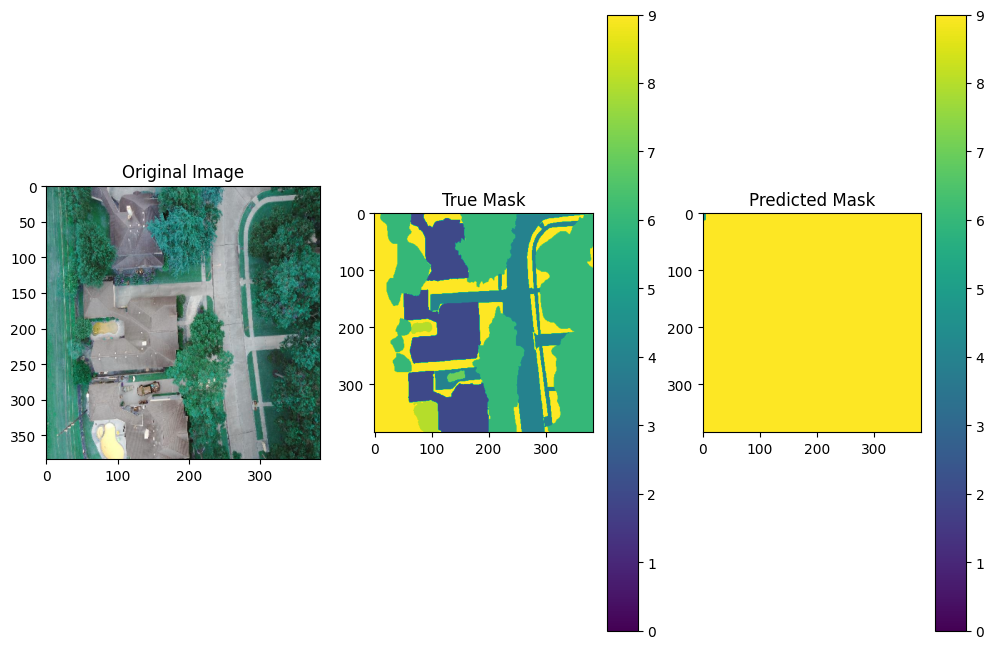

1/1 [==============================] - 1s 1s/step


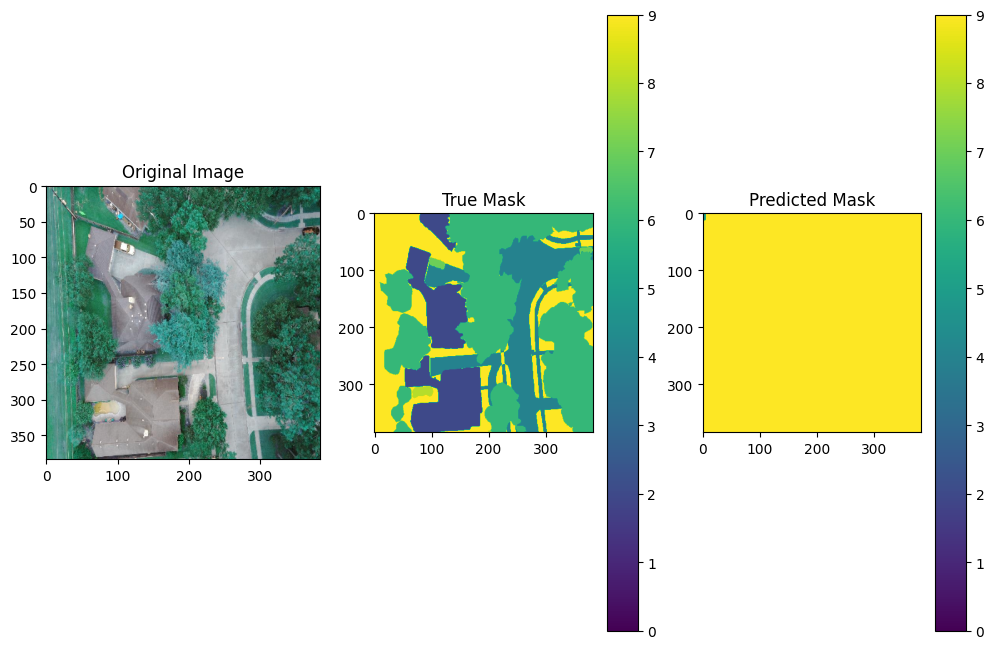

1/1 [==============================] - 1s 1s/step


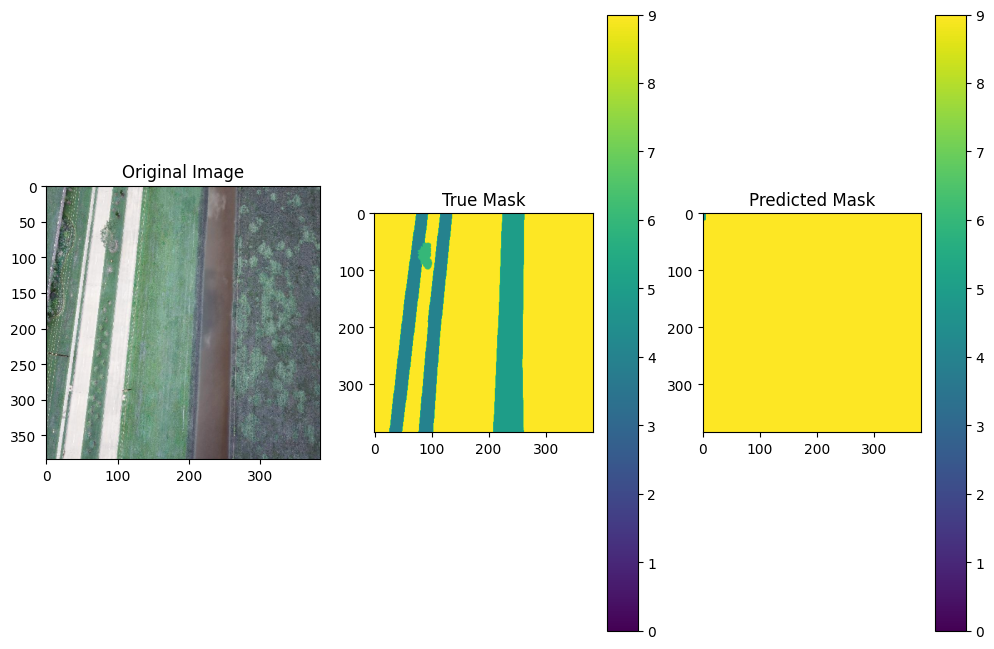

1/1 [==============================] - 1s 987ms/step


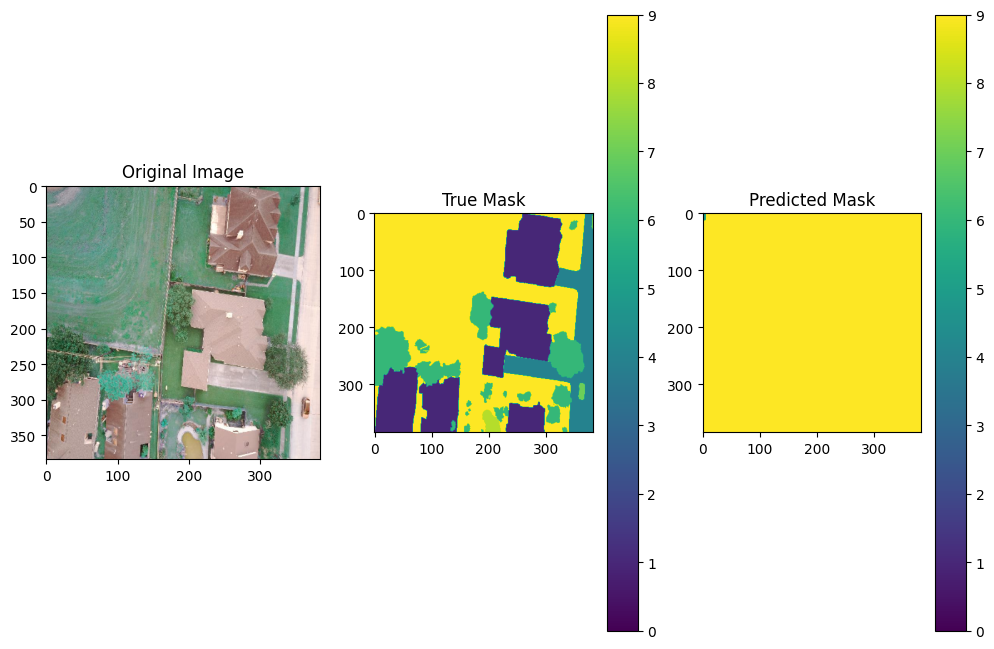

1/1 [==============================] - 1s 864ms/step


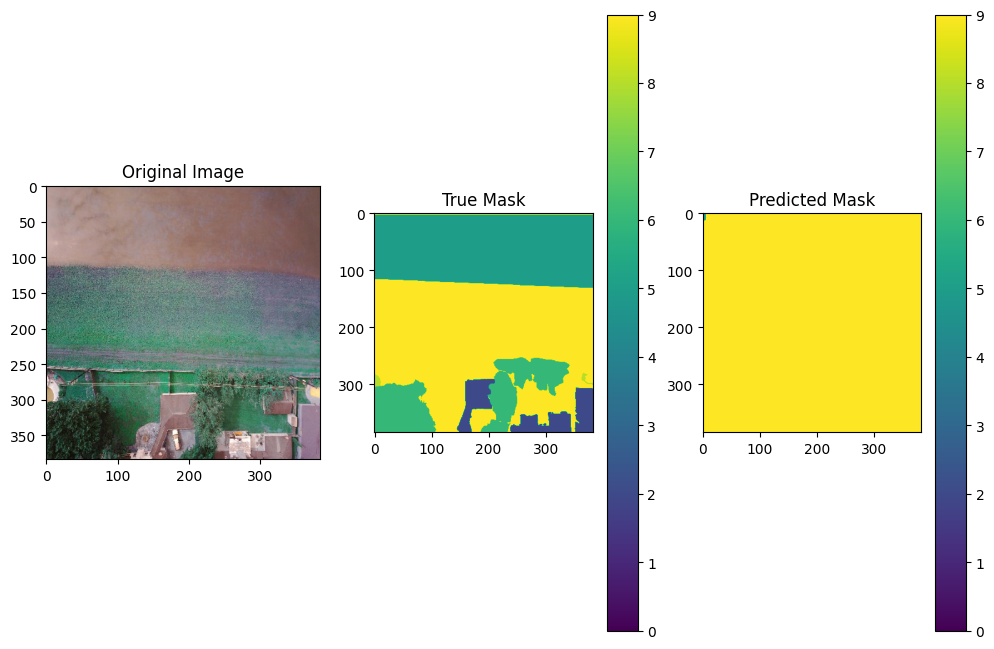

In [85]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_mask(mask, cmap='viridis', vmin=0, vmax=9):
  """Visualizes a one-hot encoded segmentation mask.
  """

  # Convert the one-hot encoded mask to a single-channel mask.
  single_channel_mask = np.argmax(mask, axis=-1)

  # Plot the mask.
  plt.imshow(single_channel_mask, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.colorbar(ticks=range(10))


def visualize_masks(image, true_mask, predicted_mask, cmap='viridis', vmin=0, vmax=9):
  """Visualizes the original image, true mask, and predicted mask next to each other.
  """
  # Initialize the figure
  plt.figure(figsize=(12, 8))

  # Plot the original image.
  plt.subplot(1, 3, 1)
  scaled_image = (image - np.min(image)) / (np.max(image) - np.min(image))
  plt.imshow(scaled_image)
  plt.title('Original Image')

  # Plot the true mask.
  plt.subplot(1, 3, 2)
  visualize_mask(true_mask, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title('True Mask')

  # Plot the predicted mask.
  plt.subplot(1, 3, 3)
  visualize_mask(predicted_mask, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title('Predicted Mask')

  plt.show()


for i, (image, true_mask) in enumerate(test_dataset):
    if i >= 5:
        break  # Stop after processing 5 samples

    # Visualize using matplotlib or other visualization libraries
    batch_size = image.shape[0]

    # Load the original image, true mask, and predicted mask.
    predicted_mask = model.predict(image)[i-1]

    # Visualize the masks.
    visualize_masks(image[i-1], true_mask[i-1], predicted_mask)

In [ ]:
#NOT USED ANYMORE
import matplotlib.pyplot as plt
import numpy as np

for i, (image, true_mask) in enumerate(test_dataset):
    if i >= 5:
        break  # Stop after processing 5 samples

    # Run model prediction for the current image
    predicted_mask = model.predict(image)[0]

    # Visualize using matplotlib or other visualization libraries
    batch_size = image.shape[0]

    for j in range(batch_size):
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 4, 1)
        #plt.imshow(image[j].numpy().astype('uint8'))
        scaled_image = (image[j] - np.min(image[j])) / (np.max(image[j]) - np.min(image[j]))
        plt.imshow(scaled_image)
        plt.colorbar()
        plt.title('Input Image')

        plt.subplot(1, 4, 2)
        plt.imshow(true_mask[j].numpy().squeeze(), cmap='viridis', vmin=0, vmax=255)
        plt.colorbar()
        plt.title('True Mask')

        plt.subplot(1, 4, 3)

        # Check if the predicted_mask has a single channel or multiple channels
        if len(predicted_mask[j].shape) == 2:
            plt.imshow(predicted_mask[j], cmap='viridis', vmin=0, vmax=1)
        else:
            plt.imshow(np.argmax(predicted_mask[j], axis=-1), cmap='viridis', vmin=0, vmax=1)

        plt.colorbar()
        plt.title('Predicted Mask')

        plt.show()
